<a href="https://colab.research.google.com/github/Victor1992/SlkimLit_nlp_milestone_project/blob/main/SlkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project NLP: SkimLit

The purpose of this notebook is to build an NLP model to make reading abstracts easier.

The paere we will be replicating (the source of the dataset that we'll be using) is availaible here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that teh model architecture that they use to achieve their best results is availaible here: https://arxiv.org/abs/1612.05251



## Confirm Access to GPU

In [1]:
!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-16d17077-a133-7426-2674-cfe396f3c427)


## Get Data

Since we are replicating the paper above (PubMed 200K), let's download the dataset.

We can do from author github:https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using  the 20K dataset with numbers replaced by @sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all our file names in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [6]:
# Function to read the lines of a document
def get_lines(filename_path):
  """
  Reads a filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename_path, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Format we want our data to look...

```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines':11},
     ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename_path):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename path, reads it contents and sorts through each line,
  extratcing things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename_path) # get all file from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if(line.startswith("###")): # check to see if the line is an ID line 
      abstract_id = line
      abstract_lines = ""   # Reset abstract string if the line is an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what the number line the target text apperar in the abstarct
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines in the target abstract? 
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line conatins a labelled sentence
      abstract_lines += line

  return abstract_samples




In [10]:
# Get data from file and preprocess
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+ "dev.txt") # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 496 ms, sys: 105 ms, total: 601 ms
Wall time: 603 ms


In [11]:
# Check the forst abstract of our training data
train_samples[:16]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data in in the form of dictionary hwo about we turn it into dataframe to further visualize it

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

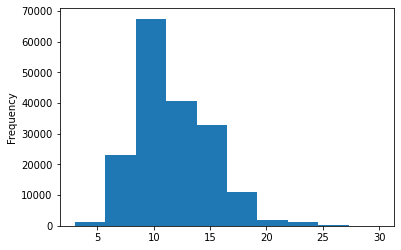

In [14]:
train_df.total_lines.plot.hist();

## Get list of sentences

In [15]:
# Convert abstract text lines into list
train_sentences  = train_df["text"].tolist()
val_sentences =  val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# view 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels()

### One hot Encoder

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # tensorflow is incompatible with sparse matrix so we put sparse=False 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [19]:
# extract labels ( target columsn) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes in Labelencoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

We will try out a bunch of different models and seeing which one works best



### Model 0: TF-IDF Multinomial naive Bayes classifier

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(X = train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# evaluate the model
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make Predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Function to calculate : accuracy, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score

  Args:
    y_true: true labels in the form of 1d array
    y_pred: predicted labels in the form of a 1d array
  
  Returns a dictionary of accuracy, precision, recall, f1-score
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = { "accuracy": model_accuracy,
                   "precision" : model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [25]:
# Calculate Baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep sequence models

Before we start building our deeper models, we'he got to craete vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long the sentence is on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

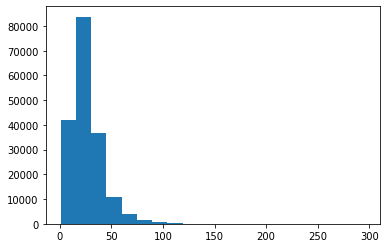

In [28]:
# what's the ditrinbution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a sentecne length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Max seq length in the training set
max(sent_lens)

296

### Create text vectorizer layer

Layer which maps our text from words to numbers

In [31]:
# How many words are in our vocab? (taken from tabel 2 in: https://arxiv.org/pdf/1710.06071.pdf)

max_tokens = 68000

In [32]:
# Create text Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in  vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [33]:
# Adapt tect vectorizer to tarining setences

text_vectorizer.adapt(train_sentences)

In [34]:
# Text our tect vectorozer on random sentence
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
data were analyzed with the use of spss software version @ .

Length of text: 60

Vectorized text: [[ 100    9  384    7    2   87    4 3370 2005 1451    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# How many words in our training vocabulary

rct_20K_text_vocab  = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20K_text_vocab)}")
print(f"Most common words in the vocab:{rct_20K_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20K_text_vocab[-5:]}")

Number of words in vocab:64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Config of Tect Vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Creating text embedding layer

In [37]:
### Create custom text embedding
token_embed = layers.Embedding(input_dim=len(rct_20K_text_vocab),
                               output_dim=128,
                               mask_zero=True, # heplps to do more efficent computing when there are lots of zeros
                               name="token_embedding")


In [38]:
print(f"Sentence before vectorizer:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded Sentence shape:\n {embedded_sentence.shape}\n")



Sentence before vectorizer:
data were analyzed with the use of spss software version @ .

Sentence after vectorization (before embedding):
[[ 100    9  384    7    2   87    4 3370 2005 1451    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.02095116 -0.03179004 -0.03334366 ... -0.04741869  0.00361804
    0.02760078]
  [ 0.01766032 -0.01338836 -0.01997708 ... -0.00397919  0.01011546
   -0.00448309]
  [ 0.03984812 -0.00483738  0.00249078 ... -0.04576819 -0.04481936
   -0.02341766]
  ...
  [ 0.02503476  0.02997238  0.00740867 ... -0.01858362  0.01554361
   -0.03254171]
  [ 0.02503476  0.02997238  0.00740867 ... -0.01858362  0.01554361
   -0.03254171]
  [ 0.02503476  0.02997238  0.00740867 ... -0.01858362  0.01554361
   -0.03254171]]]

Embedded Sentence shape:
 (1, 55, 128)



### Creating datasets (making sure our data loads as fast as posssible)

In [39]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))  

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [40]:
# Take the tensorflow's dataset and turn them into prefetched datasets

train_dataset =  train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset  = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


In [41]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [42]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
x= layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 14ms/step - loss: 0.9112 - accuracy: 0.6395 - val_loss: 0.6789 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6550 - accuracy: 0.7582 - val_loss: 0.6252 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6160 - accuracy: 0.7752 - val_loss: 0.5960 - val_accuracy: 0.7826


In [45]:
# evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5977 - accuracy: 0.7859


[0.5976547002792358, 0.7859128713607788]

In [46]:
# Make redictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.3573070e-01, 1.6342977e-01, 7.4928738e-02, 2.9283386e-01,
         3.3076849e-02],
        [4.1220832e-01, 3.0494896e-01, 1.3504020e-02, 2.5990701e-01,
         9.4317496e-03],
        [1.4902107e-01, 5.1074210e-03, 1.3082818e-03, 8.4452069e-01,
         4.2557476e-05],
        ...,
        [5.2722930e-06, 6.4897339e-04, 5.3940958e-04, 2.9855605e-06,
         9.9880338e-01],
        [5.7684194e-02, 4.4174427e-01, 1.1323091e-01, 6.5402769e-02,
         3.2193792e-01],
        [1.4613687e-01, 6.8674344e-01, 4.1687965e-02, 4.8596367e-02,
         7.6835372e-02]], dtype=float32), (30212, 5))

In [47]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds) 

In [49]:
model_1_results

{'accuracy': 78.59128822984245,
 'f1': 0.7835606293215921,
 'precision': 0.7825125050451519,
 'recall': 0.7859128822984245}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 2: Feature extraction with pretrained token embeddings



In [51]:
# Download pretrained Tensorflow h-Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [52]:
import random 
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentences:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:10]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")


Random Sentences:
the mbis-@ demonstrated good reliability and validity for the evaluation of body image among university students .
Sentence after embedding:
[-0.00485881 -0.00245756 -0.07813139 -0.00951257  0.04806846  0.05798955
  0.02210512  0.03784018 -0.07127321  0.03859548]

Length of sentence embedding:512


Building and fitting an NLP extraction model using pretrained embeddings

In [53]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation = "relu")(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Fir the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1* len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9149 - accuracy: 0.6505 - val_loss: 0.7948 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7693 - accuracy: 0.7014 - val_loss: 0.7544 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7524 - accuracy: 0.7126 - val_loss: 0.7399 - val_accuracy: 0.7141


In [56]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7427 - accuracy: 0.7132


[0.742658793926239, 0.713193416595459]

In [57]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.44168746, 0.3487611 , 0.00198939, 0.19914031, 0.0084217 ],
       [0.3606847 , 0.471391  , 0.00405585, 0.16126452, 0.00260394],
       [0.24296205, 0.16172795, 0.01919893, 0.53244674, 0.04366437],
       ...,
       [0.00190874, 0.00814939, 0.05772509, 0.00109761, 0.93111914],
       [0.00410071, 0.04536851, 0.18840602, 0.00145659, 0.7606682 ],
       [0.17012733, 0.23344384, 0.5130418 , 0.00654767, 0.07683937]],
      dtype=float32)

In [58]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) 
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [59]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.31934330729511,
 'f1': 0.7103004204460728,
 'precision': 0.7139009879328932,
 'recall': 0.7131934330729511}

In [60]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 3: Conv1D with character level embeddings

The paper which we're replicating states they used a combination of token and character-level encodings.

Previously we've token= level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings

In [61]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [62]:
def split_chars(text):
  return " ".join(list(text))

In [63]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [64]:
# Split sequence level data splits into character level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars =  [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars[:5] 

['i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'w e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   .',
 'a s t h m a t i c   p a t i e n t s   w h o   w e r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [65]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

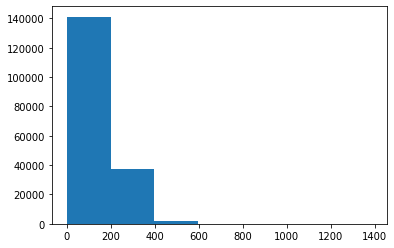

In [66]:
# Check the ditribution of our sequences at character level
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7);

In [67]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
random.choice(train_sentences)

'main outcomes were determined by assessing abdominal symptoms according to the wong-baker faces pain rating scale , calculating the volume of residual gas retention within the intestines on abdominal x-ray quantitatively and observing the cardiopulmonary states .'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and token (OOV = out of vocab. '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length = output_seq_char_len,
                                 name="char_vectorizer")

In [71]:
# For learning purpose what happens when we set  standardize=None
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and token (OOV = out of vocab. '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length = output_seq_char_len,
                                 # standardize=None,
                                 name="char_vectorizer")

char_vectorizer.adapt(train_chars)

# Check charater voccab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diff  characters vocab: {len(char_vocab)} ")
print(f"5 most common charaters: {char_vocab[:5]}")
print(f"5 least common charaters: {char_vocab[-5:]}")

Number of diff  characters vocab: 28 
5 most common charaters: ['', '[UNK]', 'e', 't', 'i']
5 least common charaters: ['k', 'x', 'z', 'q', 'j']


In [72]:
# Adapt charater vectorizer to trainig character
char_vectorizer.adapt(train_chars)

In [73]:
# Check charater voccab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diff  characters vocab: {len(char_vocab)} ")
print(f"5 most common charaters: {char_vocab[:5]}")
print(f"5 least common charaters: {char_vocab[-5:]}")

Number of diff  characters vocab: 28 
5 most common charaters: ['', '[UNK]', 'e', 't', 'i']
5 least common charaters: ['k', 'x', 'z', 'q', 'j']


In [74]:
# Test our  charater vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized Char:\n {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h i s   w o u l d   r e q u i r e   r e d u c e d   t u r n a r o u n d   t i m e   .
Length of random_train_chars: 87
\Vectorized Char:
 [[ 3 13  4  9 20  7 16 12 10  8  2 26 16  4  8  2  8  2 10 16 11  2 10  3
  16  8  6  5  8  7 16  6 10  3  4 15  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

### Creating a charater level embedding

In [75]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero = True,
                              name="char_embed"
                              )

In [76]:
# Test charater level embedding
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed Chars. (after vectorization and embedding):\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h i s   w o u l d   r e q u i r e   r e d u c e d   t u r n a r o u n d   t i m e   .

Embed Chars. (after vectorization and embedding):
[[[ 0.04639666  0.00370618  0.03046646 ... -0.04101264 -0.03665189
   -0.04041525]
  [ 0.00587329  0.04612173  0.04932728 ... -0.02747055 -0.01834295
   -0.03721638]
  [-0.01865071  0.0308785  -0.02149017 ...  0.03276389 -0.03990487
   -0.04827747]
  ...
  [-0.00683236  0.04874871  0.02406942 ...  0.0409573  -0.03390213
    0.0326934 ]
  [-0.00683236  0.04874871  0.02406942 ...  0.0409573  -0.03390213
    0.0326934 ]
  [-0.00683236  0.04874871  0.02406942 ...  0.0409573  -0.03390213
    0.0326934 ]]]
Character embedding shape: (1, 290, 25)


### Bulding a Conv1D model to fit on charater embeddings

In [82]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,outputs= outputs, name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      multiple                  700       
                                                                 
 conv1d_6 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 

In [85]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [86]:
# Fit the model on chars only

model_3_history =  model_3.fit(train_char_dataset,
                               steps_per_epoch=int(0.1 * len(train_char_dataset)),
                               epochs=3,
                               validation_data = val_char_dataset,
                               validation_steps = int(0.1* len(val_char_dataset))
                               )

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 1.4615 - accuracy: 0.3340 - val_loss: 1.4184 - val_accuracy: 0.3803
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 1.3823 - accuracy: 0.3984 - val_loss: 1.3482 - val_accuracy: 0.4279
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 1.3373 - accuracy: 0.4422 - val_loss: 1.3152 - val_accuracy: 0.4505


In [87]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17769472, 0.23609325, 0.24107598, 0.17957017, 0.16556595],
       [0.11367947, 0.17438588, 0.1685085 , 0.06621344, 0.47721264],
       [0.10676545, 0.16792074, 0.3747148 , 0.1162537 , 0.23434532],
       ...,
       [0.06978074, 0.11531477, 0.25630036, 0.04344112, 0.51516306],
       [0.05846712, 0.11309015, 0.24972226, 0.04489615, 0.5338243 ],
       [0.14423436, 0.1780151 , 0.21686317, 0.07105646, 0.38983086]],
      dtype=float32)

In [89]:
# Convert prediction probabalities to class labels
model_3_pred =  tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [91]:
model_3_results  =  calculate_results(y_true=val_labels_encoded,
                                      y_pred=model_3_pred)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.65113200052959,
 'f1': 0.39464787621954966,
 'precision': 0.3786264444482455,
 'recall': 0.4465113200052959}

### Model 4: Combining pretrained token level embeddings + character level embedings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a charater level model ( similar to `model_3`  with a slight modification)

3. Combine 1 and 2 with a concatenate (`layers.Concatenat`)
4.  Build  a series of output layers on top of 3 similar to Figure 1 and section 4.2 of   https://arxiv.org/pdf/1612.05251.pdf
5. Constrcut a model which takes token and charater-level sequences as input and produces sequence label probablities as output


#### Token level embedding model

In [99]:
# 1.
token_inputs = layers.Input(shape=[], dtype= tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs= token_outputs)



#### Set up Char inputs/model

In [100]:
# 2.
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi-LSTM shown in figure 1 ofhttps://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#### Concatenate token and Char inputs (create hybrid token embedding)

In [104]:
# Step 3.
token_char_concat = layers.Concatenate(name="token_char_hybrid")([
                                                                  token_model.output,
                                                                  char_model.output
])
token_char_concat

<KerasTensor: shape=(None, 176) dtype=float32 (created by layer 'token_char_hybrid')>

#### Create output layers

Adding in dropout, discussed in section 4.2: https://arxiv.org/pdf/1612.05251.pdf

In [105]:
# Step 4.
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

#### Construct model with char and token inputs

In [108]:
# Step 5.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [110]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

#### Plotiing hybrid model

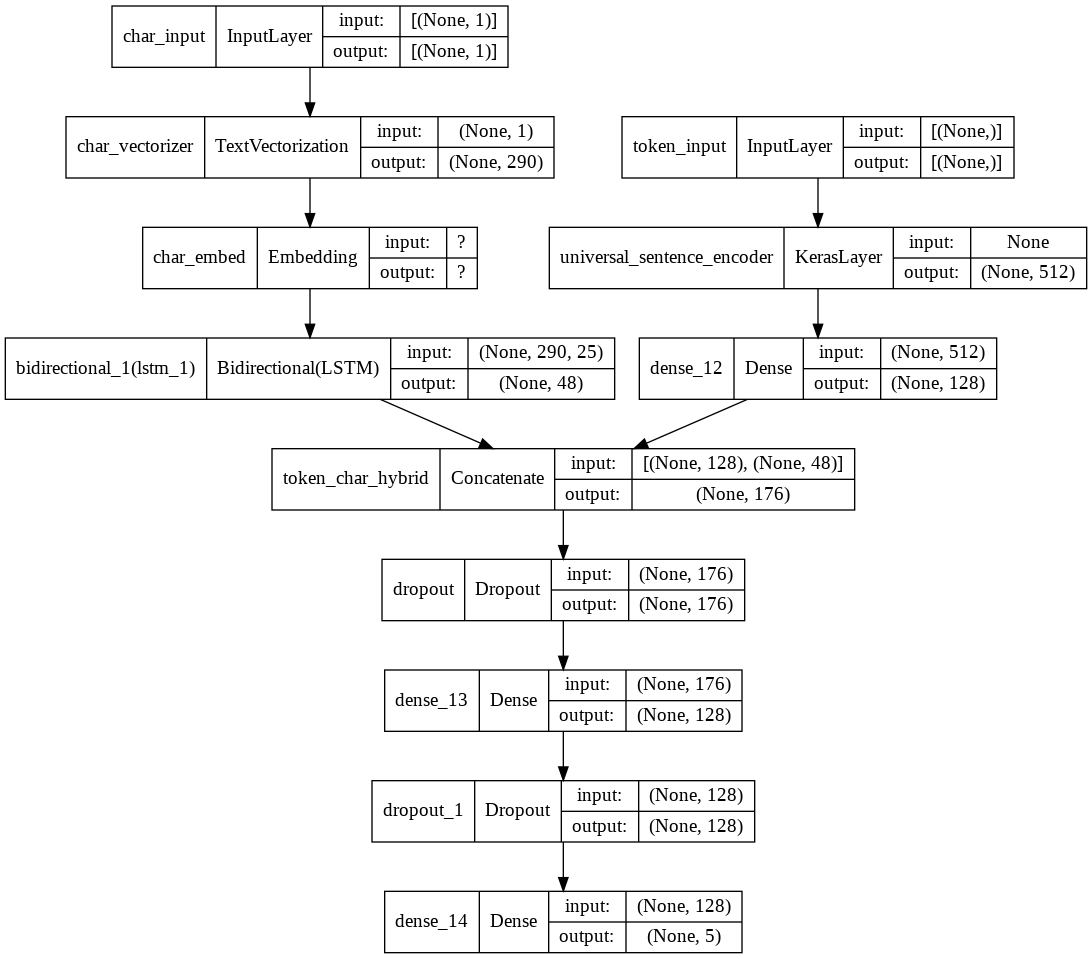

In [113]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

#### Compile the hybrid model

In [115]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Combining token and Character data to tf.data Dataset

In [118]:
# Combine Chars and token into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels =  tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset =  tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset= train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [119]:
# Repeat above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels =  tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset =  tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset= val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [120]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

#### Fitting the model on token and character-level sequences

In [122]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)) 
                              )

Epoch 1/3
562/562 [==============================] - 119s 172ms/step - loss: 0.9833 - accuracy: 0.6080 - val_loss: 0.7874 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 88s 157ms/step - loss: 0.8097 - accuracy: 0.6851 - val_loss: 0.7236 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 82s 147ms/step - loss: 0.7846 - accuracy: 0.6998 - val_loss: 0.7067 - val_accuracy: 0.7367


In [123]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 66s 69ms/step - loss: 0.7138 - accuracy: 0.7278


[0.7138471007347107, 0.7278233766555786]

In [127]:
model_4_pred_probs= model_4.predict(val_char_token_dataset)

In [128]:
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)

In [131]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_4_pred)

In [132]:
model_4_results

{'accuracy': 72.78233814378393,
 'f1': 0.7258905037281047,
 'precision': 0.7312061872442231,
 'recall': 0.7278233814378393}